In [7]:

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 256, 256
train_data_dir = "data/train"
validation_data_dir = "data/val"
test_data_dir = "data/test"
nb_train_samples = 4125
nb_validation_samples = 466 
batch_size = 32
epochs = 50

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


In [2]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:10]:
    layer.trainable = False

In [3]:

#Adding custom Layers 
x = model.output
x = Flatten(input_shape=x.shape[1:])(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(36, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,   #除以255
horizontal_flip = True,    #水平翻转
vertical_flip = True,
fill_mode = "nearest",     #One of {"constant", "nearest", "reflect" or "wrap"}，stride外的像素填充
zoom_range = 0.3,     #浮点数或形如[lower,upper]的列表，随机缩放的幅度，若为浮点数，则相当于[lower,upper] = [1 - zoom_range, 1+zoom_range]
width_shift_range = 0.3,  #浮点数，图片宽度的某个比例，数据提升时图片水平偏移的幅度
height_shift_range=0.3,   #浮点数，图片高度的某个比例，数据提升时图片竖直偏移的幅度
rotation_range=30)   #整数，数据提升时图片随机转动的角度

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')




/home/season/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  # This is added back by InteractiveShellApp.init_path()


Found 2761 images belonging to 36 classes.
Found 1049 images belonging to 36 classes.


Populating the interactive namespace from numpy and matplotlib
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


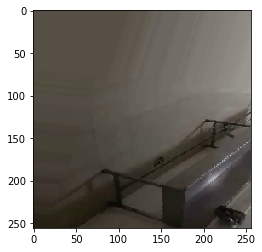

In [4]:
import matplotlib.pyplot as plt # plt 用于显示图片

#为了让画图嵌入网页中
%pylab inline
%matplotlib inline

a = train_generator.next()
print a[1]
plt.imshow(a[0][0])

In [5]:
# Train the model 
model_final.fit_generator(
train_generator,
steps_per_epoch = 2000,
epochs = 5,
validation_data = validation_generator,
validation_steps = 1000,
callbacks = [checkpoint, early])

# model_final.fit_generator(
# train_generator,
# samples_per_epoch = nb_train_samples,
# epochs = epochs,
# validation_data = validation_generator,
# nb_val_samples = nb_validation_samples,
# callbacks = [checkpoint, early])

Epoch 1/5
2000/2000 [==============================] - 2110s - loss: 1.1014 - acc: 0.6896 - val_loss: 0.2192 - val_acc: 0.9362
Epoch 2/5
2000/2000 [==============================] - 2044s - loss: 0.1891 - acc: 0.9382 - val_loss: 0.0904 - val_acc: 0.9755
Epoch 3/5
2000/2000 [==============================] - 2043s - loss: 0.0906 - acc: 0.9711 - val_loss: 0.0579 - val_acc: 0.9848
Epoch 4/5
2000/2000 [==============================] - 2042s - loss: 0.0573 - acc: 0.9819 - val_loss: 0.0431 - val_acc: 0.9885
Epoch 5/5
2000/2000 [==============================] - 2056s - loss: 0.0416 - acc: 0.9874 - val_loss: 0.0303 - val_acc: 0.9917


In [41]:
test_generator = test_datagen.flow_from_directory(
test_data_dir,
batch_size = 2000,
target_size = (img_height, img_width),
class_mode = "categorical")

#生成测试数据
a = test_generator.next()
test_X = a[0]
test_y = a[1]

#开始预测
pred_y = model_final.predict(test_X, batch_size=32, verbose=0)

pred_idx = np.argmax(pred_y,axis=1)
test_idx = np.argmax(test_y,axis=1)


Found 1527 images belonging to 36 classes.


{'101_\xe7\x8b\xac\xe7\xab\x8b\xe5\x87\xb3\xe5\xad\x90': 0,
 '102_\xe9\x98\xb3\xe5\x8f\xb0\xe9\x97\xa8': 1,
 '103_\xe6\x9f\x9c\xe5\xad\x90': 2,
 '104_\xe5\xba\x8a': 3,
 '105_\xe5\xae\xbf\xe8\x88\x8d\xe6\x9c\xa8\xe9\x97\xa8': 4,
 '106_\xe6\x9a\x96\xe6\xb0\x94\xe7\x89\x87': 5,
 '107_\xe4\xbe\x9b\xe6\x9a\x96\xe7\xae\xa1\xe9\x81\x93': 6,
 '108_\xe6\x8f\x92\xe5\xba\xa7': 7,
 '109_\xe8\xae\xb2\xe6\xa1\x8c': 8,
 '10_\xe6\x8f\x92\xe6\x8e\x92': 9,
 '110_\xe5\xa4\x9a\xe5\xaa\x92\xe4\xbd\x93': 10,
 '111_\xe5\xbc\x80\xe5\x85\xb3': 11,
 '112_\xe6\xa5\xbc\xe9\x81\x93\xe9\x97\xa8': 12,
 '113_\xe6\xa5\xbc\xe6\xa2\xaf': 13,
 '114_\xe5\x8e\x95\xe6\x89\x80\xe5\xa4\xa7\xe9\x97\xa8': 14,
 '11_\xe7\x94\xb5\xe7\xba\xbf': 15,
 '121_\xe4\xbe\xbf\xe5\x9d\x91': 16,
 '122_\xe4\xbe\xbf\xe6\xb1\xa0': 17,
 '123_\xe6\xb0\xb4\xe7\xae\xa1': 18,
 '124_\xe6\xb0\xb4\xe6\xb1\xa0': 19,
 '125_\xe5\xb0\x8f\xe5\x8e\x95\xe6\x89\x80\xe9\x97\xa8': 20,
 '126_\xe6\xb0\xb4\xe9\xbe\x99\xe5\xa4\xb4': 21,
 '141_\xe9\xa3\x8e\xe6\x89\x87

In [43]:
#一个类一个类的检查，我他么就不信了，为毛结果这么差！！
from sklearn.metrics import classification_report

inv_map = {v:k for k, v in test_generator.class_indices.items()}
class_names = [inv_map[i] for i in range(len(inv_map))]

print classification_report(test_idx, pred_idx,target_names=class_names)
# print (test_generator.class_indices)


                  precision    recall  f1-score   support

101_独立凳子       1.00      1.00      1.00        17
   102_阳台门       1.00      1.00      1.00        19
      103_柜子       1.00      1.00      1.00        15
         104_床       1.00      1.00      1.00        20
105_宿舍木门       0.93      0.88      0.90        16
   106_暖气片       1.00      1.00      1.00        13
107_供暖管道       1.00      1.00      1.00        21
      108_插座       1.00      1.00      1.00        11
      109_讲桌       1.00      1.00      1.00        36
       10_插排       0.99      1.00      1.00       128
   110_多媒体       1.00      1.00      1.00        31
      111_开关       1.00      1.00      1.00        21
   112_楼道门       1.00      1.00      1.00        26
      113_楼梯       1.00      1.00      1.00        20
114_厕所大门       0.90      1.00      0.95        18
       11_电线       1.00      1.00      1.00        93
      121_便坑       1.00      1.00      1.00        33
      122_便池       1.00      1.00      1.00  

In [17]:
#save model and weights
yaml_string = model_final.to_yaml()
text_file = open("model.txt", "w")
text_file.write(yaml_string)
text_file.close()
model_final.save_weights('weights.h5')

In [18]:
from keras.models import model_from_yaml

with open('model.txt', 'r') as myfile:
    yaml_string=myfile.read()
new_model = model_from_yaml(yaml_string)
new_model.load_weights('weights.h5')

In [19]:
#检测模型是否正确
pred_y = new_model.predict(test_X, batch_size=32, verbose=0)

pred_idx = np.argmax(pred_y,axis=1)
test_idx = np.argmax(test_y,axis=1)
#一个类一个类的检查，我他么就不信了，为毛结果这么差！！
from sklearn.metrics import classification_report

inv_map = {v:k for k, v in test_generator.class_indices.items()}
class_names = [inv_map[i] for i in range(len(inv_map))]

print classification_report(test_idx, pred_idx,target_names=class_names)
# print (test_generator.class_indices)

                  precision    recall  f1-score   support

101_独立凳子       1.00      1.00      1.00         9
   102_阳台门       1.00      1.00      1.00        12
      103_柜子       1.00      1.00      1.00        10
         104_床       1.00      1.00      1.00        13
105_宿舍木门       1.00      1.00      1.00         7
   106_暖气片       1.00      1.00      1.00        11
107_供暖管道       1.00      1.00      1.00        13
      108_插座       1.00      1.00      1.00         7
      109_讲桌       1.00      1.00      1.00        26
       10_插排       0.99      1.00      0.99        91
   110_多媒体       1.00      1.00      1.00        21
      111_开关       1.00      1.00      1.00        11
   112_楼道门       1.00      1.00      1.00        15
      113_楼梯       1.00      1.00      1.00        11
114_厕所大门       0.93      1.00      0.97        14
       11_电线       1.00      1.00      1.00        57
      121_便坑       1.00      1.00      1.00        21
      122_便池       1.00      1.00      1.00  

In [61]:
tx = test_X[test_idx==0,:,:,:]
ty = img_recognition.model.predict(tx)
tyidx = np.argmax(ty,axis=1)

In [73]:
img = Image.open('data/test/101_独立凳子/101_独立凳子29962997.jpg').resize([img_width,img_height])
pic_matrix = np.asarray(img)
pic_matrix/255.0

array([[[ 0.49803922,  0.50588235,  0.55294118],
        [ 0.49803922,  0.50588235,  0.55294118],
        [ 0.49803922,  0.50588235,  0.55294118],
        ..., 
        [ 0.45882353,  0.43529412,  0.45098039],
        [ 0.45882353,  0.43529412,  0.45098039],
        [ 0.45882353,  0.43529412,  0.45098039]],

       [[ 0.49803922,  0.50588235,  0.55294118],
        [ 0.49803922,  0.50588235,  0.55294118],
        [ 0.49803922,  0.50588235,  0.55294118],
        ..., 
        [ 0.45882353,  0.43529412,  0.45098039],
        [ 0.45882353,  0.43529412,  0.45098039],
        [ 0.45882353,  0.43529412,  0.45098039]],

       [[ 0.49803922,  0.50588235,  0.55294118],
        [ 0.49803922,  0.50588235,  0.55294118],
        [ 0.49803922,  0.50588235,  0.55294118],
        ..., 
        [ 0.45882353,  0.43529412,  0.45098039],
        [ 0.45882353,  0.43529412,  0.45098039],
        [ 0.45882353,  0.43529412,  0.45098039]],

       ..., 
       [[ 0.48235294,  0.50588235,  0.55294118],
        

In [74]:
import keras
import numpy as np
from keras.models import model_from_yaml
from PIL import Image
from PIL import ImageOps
import os
    
class ImgRecognition(object):
    u'''识别一个或者多个图片的类ImgRecognition
    def __init__(self, modelString, weights, target_names):# 初始化，参数：keras模型的描述string，权重h5，类别对应的字符名list
    '''
    img_width, img_height = 256, 256
    
    def __init__(self, model_path, weights_path, target_names):# 初始化，参数：keras模型的描述string，权重h5，类别对应的字符名list
        self.target_names = target_names       
        with open(model_path, 'r') as myfile:
            yaml_string=myfile.read()
        self.model = keras.models.model_from_yaml(yaml_string)
        self.model.load_weights(weights_path)
        
    def recognize(self, pic_file):
        img = Image.open(pic_file).resize([self.img_width,self.img_height])
        pic_matrix = np.asarray(img)/255.0
        pred_y = self.model.predict(np.expand_dims(pic_matrix, axis=0))
        pred_idx = np.argmax(pred_y,axis=1)[0]
        return  pred_idx,target_names[pred_idx]

In [75]:
#定义每个类的名字
target_names = ['101_\xe7\x8b\xac\xe7\xab\x8b\xe5\x87\xb3\xe5\xad\x90', '102_\xe9\x98\xb3\xe5\x8f\xb0\xe9\x97\xa8', '103_\xe6\x9f\x9c\xe5\xad\x90', '104_\xe5\xba\x8a', '105_\xe5\xae\xbf\xe8\x88\x8d\xe6\x9c\xa8\xe9\x97\xa8', '106_\xe6\x9a\x96\xe6\xb0\x94\xe7\x89\x87', '107_\xe4\xbe\x9b\xe6\x9a\x96\xe7\xae\xa1\xe9\x81\x93', '108_\xe6\x8f\x92\xe5\xba\xa7', '109_\xe8\xae\xb2\xe6\xa1\x8c', '10_\xe6\x8f\x92\xe6\x8e\x92', '110_\xe5\xa4\x9a\xe5\xaa\x92\xe4\xbd\x93', '111_\xe5\xbc\x80\xe5\x85\xb3', '112_\xe6\xa5\xbc\xe9\x81\x93\xe9\x97\xa8', '113_\xe6\xa5\xbc\xe6\xa2\xaf', '114_\xe5\x8e\x95\xe6\x89\x80\xe5\xa4\xa7\xe9\x97\xa8', '11_\xe7\x94\xb5\xe7\xba\xbf', '121_\xe4\xbe\xbf\xe5\x9d\x91', '122_\xe4\xbe\xbf\xe6\xb1\xa0', '123_\xe6\xb0\xb4\xe7\xae\xa1', '124_\xe6\xb0\xb4\xe6\xb1\xa0', '125_\xe5\xb0\x8f\xe5\x8e\x95\xe6\x89\x80\xe9\x97\xa8', '126_\xe6\xb0\xb4\xe9\xbe\x99\xe5\xa4\xb4', '141_\xe9\xa3\x8e\xe6\x89\x87', '142_\xe6\x8a\x95\xe5\xbd\xb1\xe4\xbb\xaa', '143_\xe9\x97\xa8', '145_\xe7\x94\xb5\xe7\x81\xaf', '147_\xe6\xa1\x8c\xe6\xa4\x85', '14_\xe6\x9a\x96\xe6\xb0\x94\xe7\x89\x87', '15_\xe6\x9a\x96\xe6\xb0\x94\xe7\xae\xa1\xe9\x81\x93', '16_\xe6\x9a\x96\xe6\xb0\x94\xe4\xba\x95\xe7\x9b\x96', '1_\xe6\xb0\xb4\xe6\xb1\xa0', '2_\xe9\xa5\xae\xe6\xb0\xb4\xe6\x9c\xba', '3_\xe6\xb6\x88\xe9\x98\xb2\xe6\xa0\x93', '6_\xe6\xb0\xb4\xe9\xbe\x99\xe5\xa4\xb4', '8_\xe6\xb0\xb4\xe7\xae\xa1', '9_\xe9\xa3\x8e\xe6\x89\x87']

#初始化识别类
img_recognition = ImgRecognition('model.txt','weights.h5',target_names)

In [76]:
img_recognition.recognize('data/test/101_独立凳子/101_独立凳子29962997.jpg')[0]

0

In [ ]:
#使用方法img_recognition.recognize(图像路径)
rootPath = 'data/test'
target_names = os.listdir(rootPath)
target_names.sort()
print(target_names)

#对于文件夹中每一个子文件夹
for x, folder in enumerate(target_names):
    for root, dirs, files in os.walk(rootPath+'/'+target_names[x]):
        print(len(files))
        for i,name in enumerate(files):
            try:
                #打开图片
                #img = Image.open(os.path.join(root, name))
                # 调用 recognize（文件路径） 进行识别。基于URL的话，尝试在这里吧图片get到，转成(w,h,3)图像矩阵pic_matrix输入，具体看代码
                print name,'---->',img_recognition.recognize(os.path.join(root, name))[1]
            except Exception,e: 
                print os.path.join(root, name)

['101_\xe7\x8b\xac\xe7\xab\x8b\xe5\x87\xb3\xe5\xad\x90', '102_\xe9\x98\xb3\xe5\x8f\xb0\xe9\x97\xa8', '103_\xe6\x9f\x9c\xe5\xad\x90', '104_\xe5\xba\x8a', '105_\xe5\xae\xbf\xe8\x88\x8d\xe6\x9c\xa8\xe9\x97\xa8', '106_\xe6\x9a\x96\xe6\xb0\x94\xe7\x89\x87', '107_\xe4\xbe\x9b\xe6\x9a\x96\xe7\xae\xa1\xe9\x81\x93', '108_\xe6\x8f\x92\xe5\xba\xa7', '109_\xe8\xae\xb2\xe6\xa1\x8c', '10_\xe6\x8f\x92\xe6\x8e\x92', '110_\xe5\xa4\x9a\xe5\xaa\x92\xe4\xbd\x93', '111_\xe5\xbc\x80\xe5\x85\xb3', '112_\xe6\xa5\xbc\xe9\x81\x93\xe9\x97\xa8', '113_\xe6\xa5\xbc\xe6\xa2\xaf', '114_\xe5\x8e\x95\xe6\x89\x80\xe5\xa4\xa7\xe9\x97\xa8', '11_\xe7\x94\xb5\xe7\xba\xbf', '121_\xe4\xbe\xbf\xe5\x9d\x91', '122_\xe4\xbe\xbf\xe6\xb1\xa0', '123_\xe6\xb0\xb4\xe7\xae\xa1', '124_\xe6\xb0\xb4\xe6\xb1\xa0', '125_\xe5\xb0\x8f\xe5\x8e\x95\xe6\x89\x80\xe9\x97\xa8', '126_\xe6\xb0\xb4\xe9\xbe\x99\xe5\xa4\xb4', '141_\xe9\xa3\x8e\xe6\x89\x87', '142_\xe6\x8a\x95\xe5\xbd\xb1\xe4\xbb\xaa', '143_\xe9\x97\xa8', '145_\xe7\x94\xb5\xe7\x81\xaf', '

10_插排66660630.jpg ----> 10_插排
10_插排49530753.jpg ----> 10_插排
10_插排49043310.jpg ----> 10_插排
10_插排75917495.jpg ----> 10_插排
10_插排48235596.jpg ----> 10_插排
10_插排20436126.jpg ----> 10_插排
10_插排23677314.jpg ----> 10_插排
10_插排98483242.jpg ----> 10_插排
10_插排71463501.jpg ----> 10_插排
10_插排548899.jpg ----> 10_插排
10_插排91444269.jpg ----> 10_插排
10_插排96769415.jpg ----> 10_插排
10_插排12090399.jpg ----> 10_插排
10_插排9640170.jpg ----> 10_插排
10_插排48270408.jpg ----> 10_插排
10_插排62010951.jpg ----> 10_插排
10_插排42567309.jpg ----> 10_插排
10_插排78126042.jpg ----> 10_插排
10_插排59040781.jpg ----> 10_插排
10_插排49294460.jpg ----> 10_插排
10_插排64152438.jpg ----> 10_插排
10_插排70452296.jpg ----> 10_插排
10_插排68866157.jpg ----> 10_插排
10_插排52312392.jpg ----> 10_插排
10_插排6603321.jpg ----> 10_插排
10_插排18943252.jpg ----> 10_插排
10_插排15435271.jpg ----> 10_插排
10_插排12752234.jpg ----> 10_插排
10_插排724328.jpg ----> 10_插排
10_插排67751445.jpg ----> 10_插排
10_插排57841132.jpg ----> 10_插排
10_插排58146903.jpg ----> 10_插排
10_插排74627295.jpg ----> 10_插排
10_插排3203007.jpg

11_电线84047252.jpg ----> 11_电线
11_电线59184616.jpg ----> 11_电线
11_电线15444987.jpg ----> 11_电线
11_电线35340754.jpg ----> 11_电线
11_电线20261712.jpg ----> 11_电线
11_电线55655851.jpg ----> 11_电线
11_电线29233928.jpg ----> 11_电线
11_电线28987122.jpg ----> 11_电线
11_电线20071200.jpg ----> 11_电线
11_电线4330571.jpg ----> 11_电线
11_电线15477561.jpg ----> 11_电线
11_电线89559526.jpg ----> 11_电线
11_电线64171758.jpg ----> 11_电线
11_电线54606847.jpg ----> 11_电线
11_电线8054582.jpg ----> 11_电线
11_电线91953774.jpg ----> 11_电线
11_电线48672329.jpg ----> 11_电线
11_电线26206874.jpg ----> 11_电线
11_电线29352310.jpg ----> 11_电线
11_电线3868788.jpg ----> 11_电线
11_电线23774562.jpg ----> 11_电线
11_电线29377500.jpg ----> 11_电线
11_电线89319667.jpg ----> 11_电线
11_电线33537454.jpg ----> 11_电线
11_电线21378653.jpg ----> 11_电线
11_电线61342050.jpg ----> 11_电线
11_电线67058355.jpg ----> 11_电线
11_电线55905021.jpg ----> 11_电线
11_电线33545260.jpg ----> 11_电线
33
121_便坑87210875.jpg ----> 121_便坑
121_便坑66514705.jpg ----> 121_便坑
121_便坑53799053.jpg ----> 121_便坑
121_便坑15287926.jpg ----> 121_便坑
12

147_桌椅72361711.jpg ----> 147_桌椅
147_桌椅47527579.jpg ----> 147_桌椅
147_桌椅2961713.jpg ----> 147_桌椅
147_桌椅15336877.jpg ----> 147_桌椅
147_桌椅5120745.jpg ----> 147_桌椅
147_桌椅30839987.jpg ----> 147_桌椅
147_桌椅86502465.jpg ----> 147_桌椅
147_桌椅715375.jpg ----> 147_桌椅
147_桌椅67251359.jpg ----> 147_桌椅
147_桌椅29202922.jpg ----> 147_桌椅
147_桌椅73723160.jpg ----> 147_桌椅
147_桌椅54317854.jpg ----> 147_桌椅
147_桌椅22586874.jpg ----> 147_桌椅
147_桌椅25200350.jpg ----> 147_桌椅
147_桌椅68982351.jpg ----> 147_桌椅
147_桌椅96407214.jpg ----> 147_桌椅
147_桌椅75292234.jpg ----> 147_桌椅
147_桌椅55632808.jpg ----> 147_桌椅
147_桌椅41325663.jpg ----> 147_桌椅
147_桌椅98655813.jpg ----> 147_桌椅
147_桌椅88085283.jpg ----> 147_桌椅
147_桌椅14812487.jpg ----> 147_桌椅
150
14_暖气片25526100.jpg ----> 14_暖气片
14_暖气片13959291.jpg ----> 14_暖气片
14_暖气片37623119.jpg ----> 14_暖气片
14_暖气片32710413.jpg ----> 14_暖气片
14_暖气片1044406.jpg ----> 14_暖气片
14_暖气片88998397.jpg ----> 14_暖气片
14_暖气片16596619.jpg ----> 14_暖气片
14_暖气片74926308.jpg ----> 14_暖气片
14_暖气片7073107.jpg ----> 14_暖气片
14_暖气片9299

16_暖气井盖41803767.jpg ----> 16_暖气井盖
16_暖气井盖13755585.jpg ----> 16_暖气井盖
16_暖气井盖56215597.jpg ----> 16_暖气井盖
16_暖气井盖92072106.jpg ----> 16_暖气井盖
16_暖气井盖49639166.jpg ----> 16_暖气井盖
16_暖气井盖49346324.jpg ----> 16_暖气井盖
16_暖气井盖63691062.jpg ----> 16_暖气井盖
16_暖气井盖73985907.jpg ----> 16_暖气井盖
16_暖气井盖60096887.jpg ----> 16_暖气井盖
16_暖气井盖4524835.jpg ----> 16_暖气井盖
16_暖气井盖24053871.jpg ----> 16_暖气井盖
16_暖气井盖56275170.jpg ----> 16_暖气井盖
16_暖气井盖34777396.jpg ----> 16_暖气井盖
16_暖气井盖30340263.jpg ----> 16_暖气井盖
16_暖气井盖40415287.jpg ----> 16_暖气井盖
16_暖气井盖12342514.jpg ----> 16_暖气井盖
16_暖气井盖66771822.jpg ----> 16_暖气井盖
16_暖气井盖57866183.jpg ----> 16_暖气井盖
16_暖气井盖91617371.jpg ----> 16_暖气井盖
16_暖气井盖39684587.jpg ----> 16_暖气井盖
16_暖气井盖72175400.jpg ----> 16_暖气井盖
16_暖气井盖29511806.jpg ----> 16_暖气井盖
16_暖气井盖15923180.jpg ----> 16_暖气井盖
16_暖气井盖63244316.jpg ----> 16_暖气井盖
16_暖气井盖5181637.jpg ----> 16_暖气井盖
16_暖气井盖30834742.jpg ----> 16_暖气井盖
16_暖气井盖48977297.jpg ----> 16_暖气井盖
16_暖气井盖73112781.jpg ----> 16_暖气井盖
16_暖气井盖94822056.jpg ----> 16_暖气井盖
16_暖气井盖39870097.

In [203]:
rootPath = 'data/train'
target_names = os.listdir(rootPath)
target_names.sort()
print(target_names)

n_width, n_height = 64,64
n_dim = n_width*n_height

for x, folder in enumerate(target_names):
    for root, dirs, files in os.walk(rootPath+'/'+target_names[x]):
        print(len(files))
        for i,name in enumerate(files):
            try:
                img = Image.open(os.path.join(root, name))
                print name,'---->',img_recognition.recognize(os.path.join(root, name))[1]
            except Exception,e: 
                print os.path.join(root, name)

['10_\xe6\x8f\x92\xe6\x8e\x92', '11_\xe7\x94\xb5\xe7\xba\xbf', '14_\xe6\x9a\x96\xe6\xb0\x94\xe7\x89\x87', '15_\xe4\xbe\x9b\xe6\x9a\x96\xe7\xae\xa1\xe9\x81\x93', '16_\xe6\x9a\x96\xe6\xb0\x94\xe4\xba\x95\xe7\x9b\x96', '1_\xe6\xb0\xb4\xe6\xb1\xa0', '2_\xe9\xa5\xae\xe6\xb0\xb4\xe6\x9c\xba', '3_\xe6\xb6\x88\xe9\x98\xb2\xe6\xa0\x93', '6_\xe6\xb0\xb4\xe9\xbe\x99\xe5\xa4\xb4', '8_\xe6\xb0\xb4\xe7\xae\xa1', '9_\xe9\xa3\x8e\xe6\x89\x87']
57
10_插排99809359.jpg ----> 6_水龙头
10_插排39618010.jpg ----> 10_插排
10_插排81601723.jpg ----> 10_插排
10_插排51364366.jpg ----> 6_水龙头
10_插排47505754.jpg ----> 10_插排
10_插排81063767.jpg ----> 10_插排
10_插排73467377.jpg ----> 6_水龙头
10_插排33607369.jpg ----> 10_插排
10_插排88694506.jpg ----> 10_插排
10_插排90109393.jpg ----> 6_水龙头
10_插排32948943.jpg ----> 6_水龙头
10_插排49923397.jpg ----> 10_插排
10_插排57128091.jpg ----> 10_插排
10_插排18473202.jpg ----> 10_插排
10_插排74753329.jpg ----> 10_插排
10_插排14474330.jpg ----> 10_插排
10_插排66604686.jpg ----> 6_水龙头
10_插排28421272.jpg ----> 10_插排
10_插排38166325.jpg ----> 1

9_风扇44725669.jpg ----> 6_水龙头
9_风扇12278915.jpg ----> 9_风扇
9_风扇66672722.jpg ----> 6_水龙头
9_风扇48007315.jpg ----> 9_风扇
9_风扇59718454.jpg ----> 9_风扇
9_风扇38323447.jpg ----> 6_水龙头
9_风扇9835215.jpg ----> 9_风扇
9_风扇69770911.jpg ----> 9_风扇
9_风扇13139844.jpg ----> 9_风扇
9_风扇63412764.jpg ----> 6_水龙头
9_风扇24212670.jpg ----> 9_风扇
9_风扇68793563.jpg ----> 9_风扇
